In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import numpy as np

In [2]:
# Load training data
train_1 = pd.read_csv("train_1.csv")

In [ ]:
# Find the basic structure
print("Shape of train_1:", train_1.shape)
print("\nColumns:", train_1.columns[:5], "...")  # Only showing first 5 columns
print("\nData types:\n", train_1.dtypes[:5])     # Again, limited view

# View the first few rows
print("\nFirst 3 rows:\n", train_1.head(3))

Shape of train_1: (145063, 551)

Columns: Index(['Page', '2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04'], dtype='object') ...

Data types:
 Page           object
2015-07-01    float64
2015-07-02    float64
2015-07-03    float64
2015-07-04    float64
dtype: object

First 3 rows:
                                       Page  2015-07-01  2015-07-02  \
0  2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0   
1   2PM_zh.wikipedia.org_all-access_spider        11.0        14.0   
2    3C_zh.wikipedia.org_all-access_spider         1.0         0.0   

   2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
0         5.0        13.0        14.0         9.0         9.0        22.0   
1        15.0        18.0        11.0        13.0        22.0        11.0   
2         1.0         1.0         0.0         4.0         0.0         3.0   

   2015-07-09  ...  2016-12-22  2016-12-23  2016-12-24  2016-12-25  \
0        26.0  ...        32.0        63.0        15

In [ ]:
# Check for missing values
na_counts = train_1.isna().sum()
na_summary = na_counts[na_counts > 0].sort_values(ascending=False)
print("\nMissing values per column (only those with NAs):\n", na_summary)


Missing values per column (only those with NAs):
 2015-07-02    20816
2015-07-01    20740
2015-07-07    20664
2015-07-05    20659
2015-07-04    20654
              ...  
2016-12-12     3538
2016-12-31     3465
2016-12-20     3268
2016-12-21     3236
2016-12-24     3189
Length: 550, dtype: int64


In [5]:
# Descriptive stats (excluding Page column if present)
if 'Page' in train_1.columns:
    print("\nDescriptive stats for time series values:\n", train_1.drop('Page', axis=1).describe())
else:
    print("\nDescriptive stats:\n", train_1.describe())
    
    
# Assuming dates start from column 1 onward
date_columns = train_1.columns[1:] if 'Page' in train_1.columns else train_1.columns
date_range = pd.to_datetime(date_columns)

print(f"\nNumber of time series: {train_1.shape[0]}")
print(f"Number of time points: {len(date_columns)}")
print(f"Date range: {date_range.min().date()} to {date_range.max().date()}")


Descriptive stats for time series values:
          2015-07-01    2015-07-02    2015-07-03    2015-07-04    2015-07-05  \
count  1.243230e+05  1.242470e+05  1.245190e+05  1.244090e+05  1.244040e+05   
mean   1.195857e+03  1.204004e+03  1.133676e+03  1.170437e+03  1.217769e+03   
std    7.275352e+04  7.421515e+04  6.961022e+04  7.257351e+04  7.379612e+04   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.300000e+01  1.300000e+01  1.200000e+01  1.300000e+01  1.400000e+01   
50%    1.090000e+02  1.080000e+02  1.050000e+02  1.050000e+02  1.130000e+02   
75%    5.240000e+02  5.190000e+02  5.040000e+02  4.870000e+02  5.400000e+02   
max    2.038124e+07  2.075219e+07  1.957397e+07  2.043964e+07  2.077211e+07   

         2015-07-06    2015-07-07    2015-07-08    2015-07-09    2015-07-10  \
count  1.245800e+05  1.243990e+05  1.247690e+05  1.248190e+05  1.247210e+05   
mean   1.290273e+03  1.239137e+03  1.193092e+03  1.197992e+03  1.189651e+03   
std    

In [6]:
# Count all-zero time series
zero_series = (train_1.iloc[:, 1:] == 0).all(axis=1).sum()
print(f"\nNumber of all-zero time series: {zero_series}")

# Count constant (flat) series
const_series = train_1.iloc[:, 1:].nunique(axis=1)
num_const = (const_series == 1).sum()
print(f"Number of constant (flat) time series: {num_const}")


Number of all-zero time series: 1
Number of constant (flat) time series: 146


In [7]:
# Step 1: Drop all-zero and flat series
# All-zero series
all_zero = (train_1.iloc[:, 1:] == 0).all(axis=1)

# Flat (constant) series
flat = train_1.iloc[:, 1:].nunique(axis=1) == 1

# Drop them
cleaned_df = train_1[~(all_zero | flat)].copy()

print(f"Dropped {all_zero.sum()} all-zero and {flat.sum()} flat series.")
print(f"Remaining series: {cleaned_df.shape[0]}")

Dropped 1 all-zero and 146 flat series.
Remaining series: 144917


In [8]:
# Split metadata before melting — MUCH faster
page_split = cleaned_df['Page'].str.rsplit('_', n=3, expand=True)
page_split.columns = ['title', 'language', 'access_type', 'agent_type']
cleaned_df = pd.concat([cleaned_df.reset_index(drop=True), page_split], axis=1)

In [9]:
# Step 2: Reshape to long format
long_df = cleaned_df.melt(id_vars=['Page', 'title', 'language', 'access_type', 'agent_type'], var_name='date', value_name='views')
long_df['date'] = pd.to_datetime(long_df['date'])

In [10]:
# Step 3: Impute missing values
# Here, we assume missing means no data => fill with 0
long_df['views'] = long_df['views'].fillna(0)


In [11]:
# Add to long_df
long_df = pd.concat([long_df.reset_index(drop=True), page_split], axis=1)

In [12]:
# Step 4: Add time-based features
long_df['day'] = long_df['date'].dt.day
long_df['month'] = long_df['date'].dt.month
long_df['dayofweek'] = long_df['date'].dt.dayofweek
long_df['is_weekend'] = long_df['dayofweek'].isin([5, 6]).astype(int)

print("\nSample of cleaned and reshaped data:")
print(long_df.head())


Sample of cleaned and reshaped data:
                                                Page             title  \
0            2NE1_zh.wikipedia.org_all-access_spider              2NE1   
1             2PM_zh.wikipedia.org_all-access_spider               2PM   
2              3C_zh.wikipedia.org_all-access_spider                3C   
3         4minute_zh.wikipedia.org_all-access_spider           4minute   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...  52_Hz_I_Love_You   

           language access_type agent_type       date  views  \
0  zh.wikipedia.org  all-access     spider 2015-07-01   18.0   
1  zh.wikipedia.org  all-access     spider 2015-07-01   11.0   
2  zh.wikipedia.org  all-access     spider 2015-07-01    1.0   
3  zh.wikipedia.org  all-access     spider 2015-07-01   35.0   
4  zh.wikipedia.org  all-access     spider 2015-07-01    0.0   

              title          language access_type agent_type  day  month  \
0              2NE1  zh.wikipedia.org  all-access     sp

In [13]:
# Ensure the data is sorted properly
long_df = long_df.sort_values(['Page', 'date'])

# Group by Page
grouped = long_df.groupby('Page')

# Lag features
long_df['lag_1'] = grouped['views'].shift(1)
long_df['lag_7'] = grouped['views'].shift(7)
long_df['lag_28'] = grouped['views'].shift(28)

# Rolling features (trailing 7, 14, 28 days, excluding current day)
for window in [7, 28]:
    long_df[f'rolling_mean_{window}'] = grouped['views'].shift(1).rolling(window).mean().reset_index(level=0, drop=True)
    long_df[f'rolling_std_{window}'] = grouped['views'].shift(1).rolling(window).std().reset_index(level=0, drop=True)

lag_rolling_features = [
    'lag_1', 'lag_7', 'lag_28',
    'rolling_mean_7', 'rolling_std_7',
    'rolling_mean_28', 'rolling_std_28'
]

# Drop rows with NA values from lag/rolling features (only from the start of each series)
long_df = long_df.dropna(subset=lag_rolling_features)

print("\nSample with lag and rolling features:")
print(long_df[['Page', 'date', 'views', 'lag_1', 'lag_7', 'lag_28', 'rolling_mean_7', 'rolling_std_7', 'rolling_mean_28', 'rolling_std_28' ]].head())


Sample with lag and rolling features:
                                                 Page       date  views  \
4098928  !vote_en.wikipedia.org_all-access_all-agents 2015-07-29    4.0   
4243991  !vote_en.wikipedia.org_all-access_all-agents 2015-07-30    6.0   
4389054  !vote_en.wikipedia.org_all-access_all-agents 2015-07-31    4.0   
4534117  !vote_en.wikipedia.org_all-access_all-agents 2015-08-01    2.0   
4679180  !vote_en.wikipedia.org_all-access_all-agents 2015-08-02    1.0   

         lag_1  lag_7  lag_28  rolling_mean_7  rolling_std_7  rolling_mean_28  \
4098928   10.0    8.0     3.0      119.142857      23.688482       163.535714   
4243991    4.0    5.0     4.0      124.000000      36.959455       100.642857   
4389054    6.0    1.0     7.0       35.428571      59.994059        16.964286   
4534117    4.0    2.0     4.0      161.714286      46.796433       183.535714   
4679180    2.0    1.0     4.0     1967.857143      96.459721      2042.678571   

         rolling_std_28

In [14]:
# Split based on date
cutoff_date = pd.to_datetime("2016-12-01")
train_df = long_df[long_df['date'] < cutoff_date]
val_df   = long_df[long_df['date'] >= cutoff_date]

# Confirm sizes
print(f"Training size: {train_df.shape[0]}")
print(f"Validation size: {val_df.shape[0]}")

Training size: 67531826
Validation size: 4187657


In [23]:
# Categorical and numeric features
categorical_features = ['language', 'access_type', 'agent_type']

features = [
    'day', 'month', 'dayofweek', 'is_weekend',
    'lag_1', 'lag_7', 'lag_28', 'rolling_mean_7', 'rolling_std_7', 
    'rolling_mean_28', 'rolling_std_28',
    'language', 'access_type', 'agent_type'
]

In [24]:
#Take a sample of 2 million rows (or fewer if needed):
# Much safer sampling using iloc (no shuffling, minimal RAM use)
train_df_sampled = train_df.iloc[:1_000_000].copy()
val_df_sampled = val_df.iloc[:100_000].copy()

In [25]:
# Remove duplicate columns if any
train_df_sampled = train_df_sampled.loc[:, ~train_df_sampled.columns.duplicated()]
val_df_sampled = val_df_sampled.loc[:, ~val_df_sampled.columns.duplicated()]

In [26]:
for col in features:
    if col not in train_df_sampled.columns:
        print(f"Missing feature in train: {col}")
    if col not in val_df_sampled.columns:
        print(f"Missing feature in val: {col}")


In [27]:
# STEP 2: Apply log1p transformation
train_df_sampled['log_views'] = np.log1p(train_df_sampled['views'])
val_df_sampled['log_views'] = np.log1p(val_df_sampled['views'])

In [28]:
#Downcast your categorical columns
#Convert string features to category dtype before passing to LightGBM — this is both faster and more memory efficient:
# Downcast only the needed columns
for col in ['language', 'access_type', 'agent_type']:
    train_df_sampled[col] = train_df_sampled[col].astype('category')
    val_df_sampled[col] = val_df_sampled[col].astype('category')

print(train_df_sampled[categorical_features].dtypes)
print(val_df_sampled[categorical_features].dtypes)

language       category
access_type    category
agent_type     category
dtype: object
language       category
access_type    category
agent_type     category
dtype: object


In [29]:
# Grid search for LightGBM parameters
params = {
    'n_estimators': [100,200],
    'learning_rate': [0.1, 0.05],
    'num_leaves': [32, 64],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [30]:
X_train_sample = train_df_sampled[features].iloc[:100_000]
y_train_sample = train_df_sampled['log_views'].iloc[:100_000]

In [32]:
print("\nTraining LightGBM on sampled data...")

lgbm = LGBMRegressor(objective='regression', random_state=42)
grid = GridSearchCV(
    lgbm, params, scoring='neg_root_mean_squared_error',
    cv=3, verbose=2, n_jobs=-1 
)

grid.fit(X_train_sample, y_train_sample)
print("Best Parameters are: ",grid.best_params_)

best_lgbm = LGBMRegressor(objective='regression', random_state=42, **grid.best_params_)
best_lgbm.fit(
    train_df_sampled[features], train_df_sampled['log_views'],
    eval_set=[(val_df_sampled[features], val_df_sampled['log_views'])],
    eval_metric='rmse',
    categorical_feature=categorical_features
)


Training LightGBM on sampled data...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1856
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 14
[LightGBM] [Info] Start training from score 4.048840
Best Parameters are:  {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 32, 'subsample': 0.8}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1856
[LightGBM] [Info] Number of data points in the train set: 1000000, number of used features: 14
[LightGBM] 

LGBMRegressor(learning_rate=0.05, num_leaves=32, objective='regression',
              random_state=42, subsample=0.8)

In [33]:
# Predict and evaluate
val_pred_log = best_lgbm.predict(val_df_sampled[features], num_iteration=best_lgbm.best_iteration_)
val_pred = np.expm1(val_pred_log)
val_actual = val_df_sampled['views'].values
rmse = np.sqrt(mean_squared_error(val_actual, val_pred))
print(f"\nValidation RMSE (sampled): {rmse:.3f}")


Validation RMSE (sampled): 45301.199


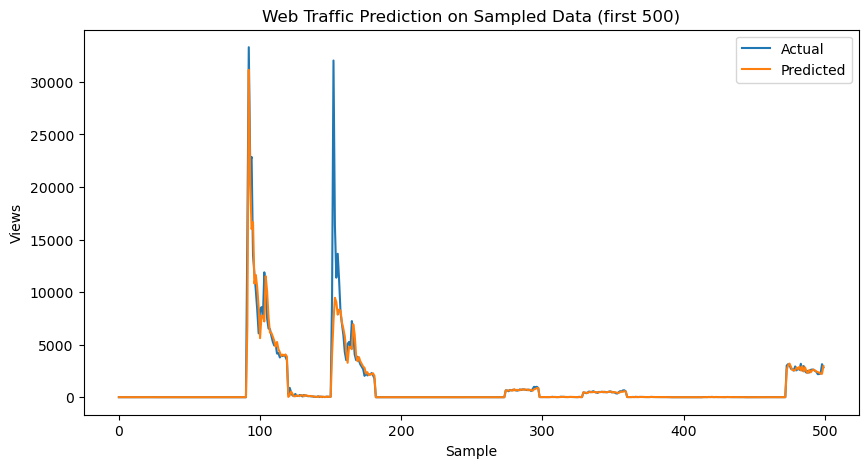

In [37]:
plt.figure(figsize=(10, 5))
plt.plot(val_actual[:500], label='Actual')
plt.plot(val_pred[:500], label='Predicted')
plt.title("Web Traffic Prediction on Sampled Data (first 500)")
plt.xlabel("Sample")
plt.ylabel("Views")
plt.legend()
plt.show()

In [38]:
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff) * 100

print(f"SMAPE: {smape(val_actual, val_pred):.2f}%")

SMAPE: 32.55%


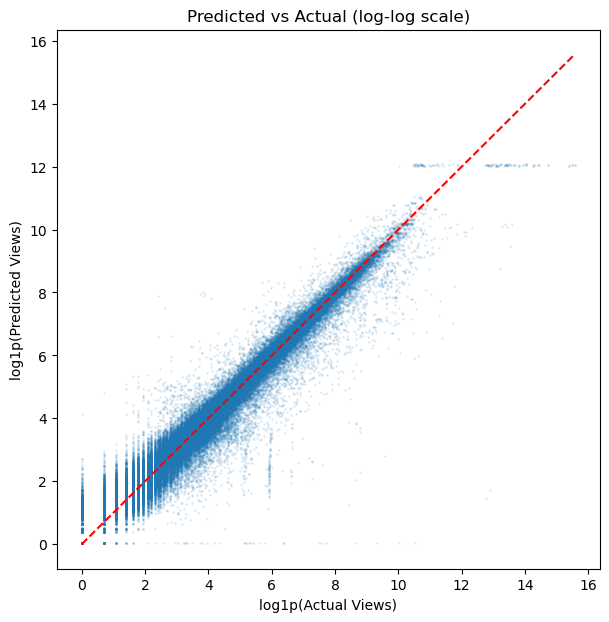

In [44]:
plt.figure(figsize=(7, 7))
plt.scatter(np.log1p(val_actual), np.log1p(val_pred), alpha=0.1, s=1)
plt.plot([0, np.log1p(val_actual).max()], [0, np.log1p(val_actual).max()], 'r--')
plt.xlabel("log1p(Actual Views)")
plt.ylabel("log1p(Predicted Views)")
plt.title("Predicted vs Actual (log-log scale)")
plt.show()

In [ ]:
print("Validation target stats:")
print(val_df_sampled['views'].describe())

Validation target stats:
count    1.000000e+05
mean     1.750093e+03
std      4.891293e+04
min      0.000000e+00
25%      2.000000e+01
50%      7.400000e+01
75%      4.750000e+02
max      5.783441e+06
Name: views, dtype: float64
